<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Project_Solution/StandaloneDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vision Systems Lab Project

#### Standalone demo

This notebook is a copy of *StandaloneDemo.ipynb* which runs on other machines.

In [1]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm
import shutil
import random
from PIL import Image
import os
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler
import torch.jit as jit
from asset.utils import *
from datasets import DisparityDataset
from transforms import RandomCrop, DisparityTransform, DisparityTransformCompose
from trainer import Trainer
from torch.utils.data import ConcatDataset

In [2]:
MEAN, STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
                                       RandomCrop(output_size=(256,512))])

transform_large = DisparityTransformCompose([DisparityTransform(transforms.Normalize(MEAN, STD), apply_to_disparity=False),
                                       RandomCrop(output_size=(368,1220))])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)


kitti_dataset = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform)
kitti_dataset_large = DisparityDataset(get_left_frames_kitti(), left_to_right_kitti, left_to_disparity_kitti, load_image_kitti, load_disparity_kitti, transform_large)
print('Number of samples in the KITTI dataset:', len(kitti_dataset))

monkaa_dataset = DisparityDataset(get_left_frames_monkaa(), left_to_right_monkaa, left_to_disparity_monkaa, load_image_sceneflow, load_disparity_sceneflow, transform)
driving_dataset = DisparityDataset(get_left_frames_driving(), left_to_right_driving, left_to_disparity_driving, load_image_sceneflow, load_disparity_sceneflow, transform)
flyingthings3d_dataset = DisparityDataset(get_left_frames_flyingthings3d(use_difficult_examples=False), left_to_right_flyingthings3d, left_to_disparity_flyingthings3d, load_image_sceneflow, load_disparity_sceneflow, transform)
print('Number of samples in the Monkaa dataset:', len(monkaa_dataset))
print('Number of samples in the Driving dataset:', len(driving_dataset))
print('Number of samples in the Flyingthings3d dataset:', len(flyingthings3d_dataset))
concat_dataset = ConcatDataset([monkaa_dataset, driving_dataset, flyingthings3d_dataset])
print('Number of samples in the concatenated Sceneflow dataset:', len(concat_dataset))

Number of samples in the KITTI dataset: 200
Number of samples in the Monkaa dataset: 8664
Number of samples in the Driving dataset: 4400
Number of samples in the Flyingthings3d dataset: 26066
Number of samples in the concatenated Sceneflow dataset: 39130


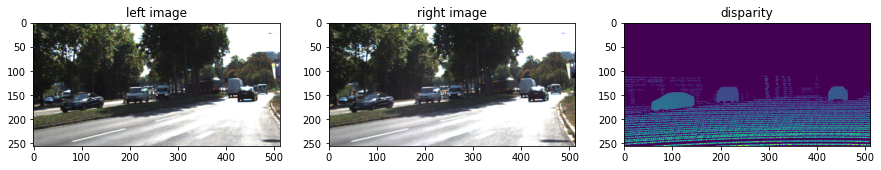

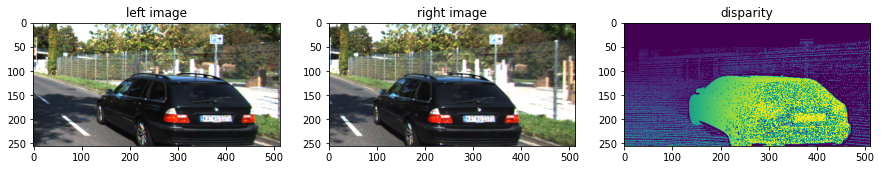

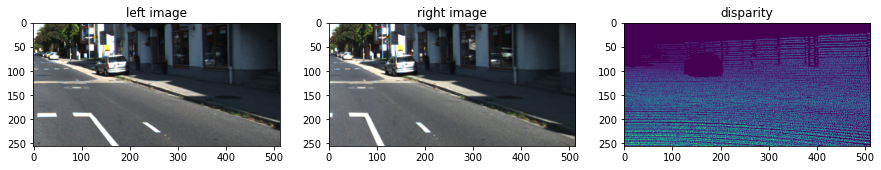

In [3]:
for i in np.random.choice(np.arange(len(kitti_dataset)), size=3, replace=False):
    (img_left, img_right), img_disparity = kitti_dataset[i]
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze())
    axes[2].set_title('disparity')
    
    plt.show()

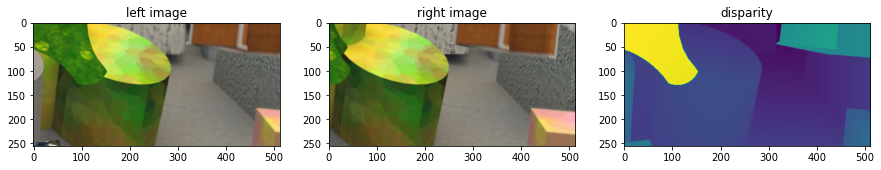

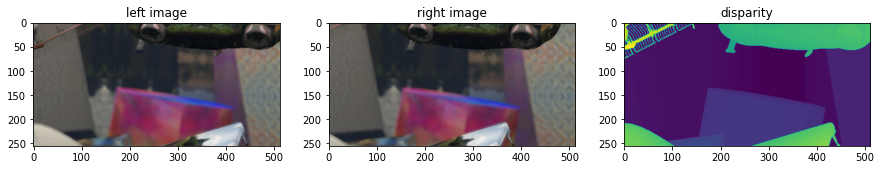

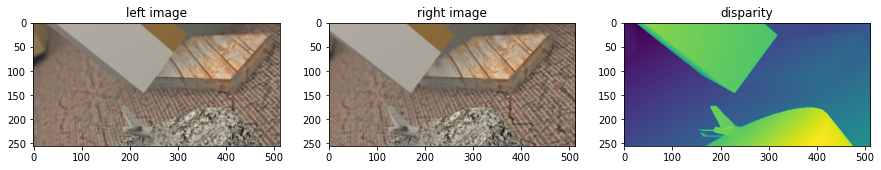

In [4]:
for i in np.random.choice(np.arange(len(concat_dataset)), size=3, replace=False):
    (img_left, img_right), img_disparity = concat_dataset[i]
    
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze())
    axes[2].set_title('disparity')
    
    plt.show()

### Dataloader

In [5]:
BATCHSIZE = 25
BATCHSIZE_VALID = 5 # Relevant because the images are larger
train_share = 0.75
N_samples = len(kitti_dataset)
indices = list(range(N_samples))
split = int(np.ceil(train_share * N_samples))
#np.random.shuffle(indices)

train_idx, valid_idx = indices[:split], indices[split:]
print(len(train_idx), len(valid_idx))
trainset = torch.utils.data.Subset(kitti_dataset, train_idx)
validset = torch.utils.data.Subset(kitti_dataset_large, valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=10)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCHSIZE_VALID, shuffle=False, num_workers=10)

train_share_concat = 0.8
N_samples_concat = len(concat_dataset)
indices_concat = list(range(N_samples_concat))
split_concat = int(np.ceil(train_share_concat * N_samples_concat))
np.random.seed(42)
np.random.shuffle(indices_concat)


BATCHSIZE_CONCAT = 25
BATCHSIZE_CONCAT_VALID = 100
train_idx_concat, valid_idx_concat = indices_concat[:split_concat], indices_concat[split_concat:]
print(len(train_idx_concat), len(valid_idx_concat))
trainset_concat = torch.utils.data.Subset(concat_dataset, train_idx_concat)
validset_concat = torch.utils.data.Subset(concat_dataset, valid_idx_concat)

trainloader_concat = torch.utils.data.DataLoader(trainset_concat, batch_size=BATCHSIZE_CONCAT, shuffle=True, num_workers=10)
validloader_concat = torch.utils.data.DataLoader(validset_concat, batch_size=BATCHSIZE_CONCAT_VALID, shuffle=False, num_workers=10)

150 50
31304 7826


### Model

In [12]:
# squeeze layer
class Squeeze(jit.ScriptModule):
    def __init__(self, dim):
        super(Squeeze, self).__init__()
        self.dim = dim
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        return x.squeeze(self.dim)


# disparity expectation layer
class Expectation(jit.ScriptModule):
    def __init__(self, max_disp):
        super(Expectation, self).__init__()
        # this is a parameter without grad to ensure model.cuda() behaves as expected
        self.weights = nn.parameter.Parameter(torch.arange(max_disp).float(), requires_grad=False)
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        return (x.permute(0,2,3,1) @ self.weights).unsqueeze(1)


# cost volume construction is taken from the lab slides
class CostBuilder(jit.ScriptModule):
    def __init__(self, max_disp):
        super(CostBuilder, self).__init__()
        self.max_disp = max_disp
    
    @jit.script_method
    def forward(self, left_feats, right_feats):
        # type: (Tensor, Tensor) -> Tensor
        B, C, H_prime, W_prime = left_feats.shape
        cost = torch.zeros(B, 2*C, self.max_disp//4, H_prime, W_prime).to(left_feats.device)
        for i in range(self.max_disp//4):
            if i==0:
                cost[:,:C,i,:,:] = left_feats
                cost[:,C:,i,:,:] = right_feats
            else:
                cost[:,:C,i,:,i:] = left_feats[:,:,:,i:]
                cost[:,C:,i,:,i:] = right_feats[:,:,:,:-i]
        return cost


# residual blocks are built like shown in https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(jit.ScriptModule):
    def __init__(self, inplanes, planes, stride = 1, norm_layer = None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = None if (stride == 1 and inplanes == planes) else nn.Sequential(conv1x1(inplanes, planes, stride), norm_layer(planes))
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out
    

def conv3d3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv3d:
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv3d1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv3d:
    """1x1 convolution"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

    
class BasicBlock3D(jit.ScriptModule):
    def __init__(self, inplanes, planes, stride = 1, norm_layer = None):
        super(BasicBlock3D, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm3d
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3d3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3d3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = None if (stride == 1 and inplanes == planes) else nn.Sequential(conv3d1x1(inplanes, planes, stride), norm_layer(planes))
    
    @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tensor
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out


class BaselineModel(jit.ScriptModule):
    def __init__(self, in_channels=3, max_disp=136):
        super(BaselineModel, self).__init__()
        # features:
        # in: B  x  3 x H    x W
        # out: B x 32 x H//4 x W//4
        self.features = nn.Sequential(
            BasicBlock(inplanes= 3, planes= 8, stride=1),
            BasicBlock(inplanes= 8, planes= 8, stride=1),
            BasicBlock(inplanes= 8, planes=16, stride=2),
            BasicBlock(inplanes=16, planes=16, stride=1),
            BasicBlock(inplanes=16, planes=16, stride=1),
            BasicBlock(inplanes=16, planes=32, stride=2),
            BasicBlock(inplanes=32, planes=32, stride=1),
            BasicBlock(inplanes=32, planes=32, stride=1)
        )
        # cost volume
        # in: 2 of B x 32           x H//4 x W//4
        # out:     B x 64 x Disp//4 x H//4 x W//4
        self.build_cost = CostBuilder(max_disp=max_disp)
        # 3d convs
        # in:  B x 64 x Disp//4 x H//4 x W//4
        # out: B x  1 x Disp//4 x H//4 x W//4
        self.conv_3d = nn.Sequential(
            BasicBlock3D(inplanes=64, planes=32),
            BasicBlock3D(inplanes=32, planes=16),
            BasicBlock3D(inplanes=16, planes= 8),
            BasicBlock3D(inplanes= 8, planes= 1)
        )
        # regressor
        # in:  B x 1 x Disp//4 x H//4 x W//4
        # out: B x 1           x H    x W
        self.regressor = nn.Sequential(
            #nn.ConvTranspose3d(1, 1, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
            #nn.ConvTranspose3d(1, 1, kernel_size=3, stride=2, padding=1, bias=False, output_padding=1),
            nn.Upsample(scale_factor=4),
            Squeeze(dim=1),
            torch.nn.Softmax(dim=1),
            Expectation(max_disp)
            )
    
    @jit.script_method
    def forward(self, img_left, img_right):
        # type: (Tensor, Tensor) -> Tensor
        feat_left, feat_right = self.features(img_left), self.features(img_right)
        cost_volume = self.build_cost(feat_left, feat_right)
        disp_features = self.conv_3d(cost_volume)
        return self.regressor(disp_features)

### Loss Functions

In [13]:
class NonZeroWrapper(nn.Module):
    def __init__(self, criterion, eps=0):
        super(NonZeroWrapper, self).__init__()
        self.criterion = criterion
        self.eps = eps
    def forward(self, x, target):
        mask = target > self.eps
        loss = self.criterion(x, target)
        return loss[mask].mean()

criterion_smoothl1 = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
wrapped_criterion_smoothl1 = NonZeroWrapper(torch.nn.SmoothL1Loss(reduction='none', beta=1.0))

### Training

In [ ]:
model = BaselineModel()

title = 'Baseline Model Pretrain'
baseline_trainer_pretrain = Trainer(model, criterion_smoothl1, trainloader_concat, validloader_concat, es_mode='min', description=title, patience=5, lr=1e-3, n_epochs=25)
baseline_trainer_pretrain.fit()

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
plot_history(baseline_trainer_pretrain)

In [ ]:
(imgs_left, imgs_right), imgs_disparity, net_outs = baseline_trainer_pretrain.get_sample()

In [ ]:
plt.style.use('default')
for i in range(imgs_left.shape[0]):
    img_left = imgs_left[i]
    img_right = imgs_right[i]
    img_disparity = imgs_disparity[i]
    disp_min, disp_max = img_disparity.min(), img_disparity.max()
    mask = img_disparity == 0
    net_out = net_outs[i].clone()
    
    _, axes = plt.subplots(1, 6, figsize=(30, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[2].set_title('disparity')

    axes[3].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[3].set_title('network output')

    net_out[mask] = 0
    axes[4].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[4].set_title('masked network output')
    
    err = torch.abs(img_disparity.squeeze() - net_out.squeeze())
    axes[5].imshow(err)
    axes[5].set_title(f'abs. error - max: {err.max() :.4f}')

    plt.show()

In [14]:
model = BaselineModel() #baseline_trainer_pretrain.model

title = 'Baseline Model'
baseline_trainer = Trainer(model, wrapped_criterion_smoothl1, trainloader, validloader, es_mode='min', description=title, patience=6, lr=1e-3)
baseline_trainer.fit()

  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


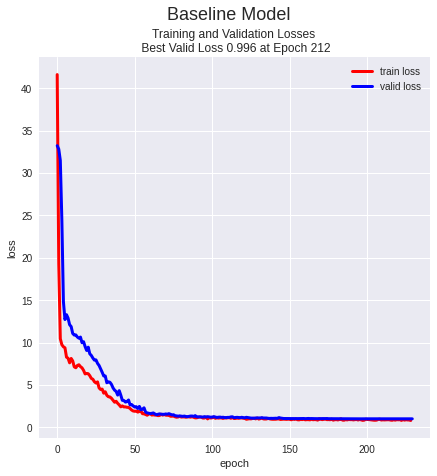

In [15]:
plot_history(baseline_trainer)

In [16]:
(imgs_left, imgs_right), imgs_disparity, net_outs = baseline_trainer.get_sample()

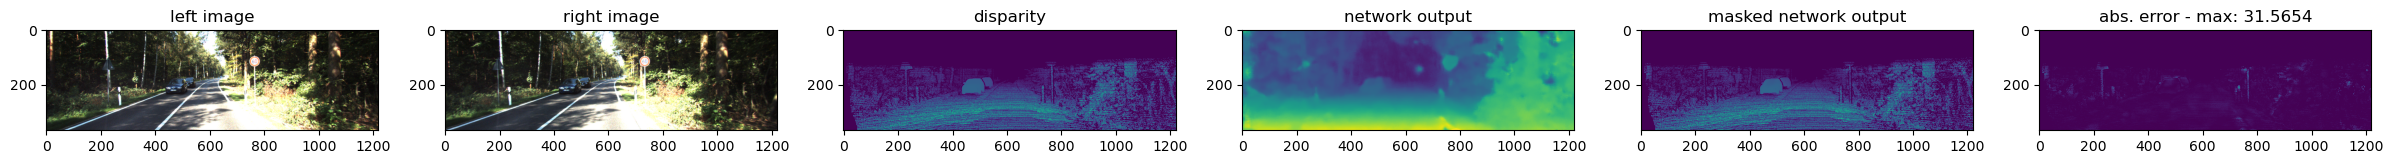

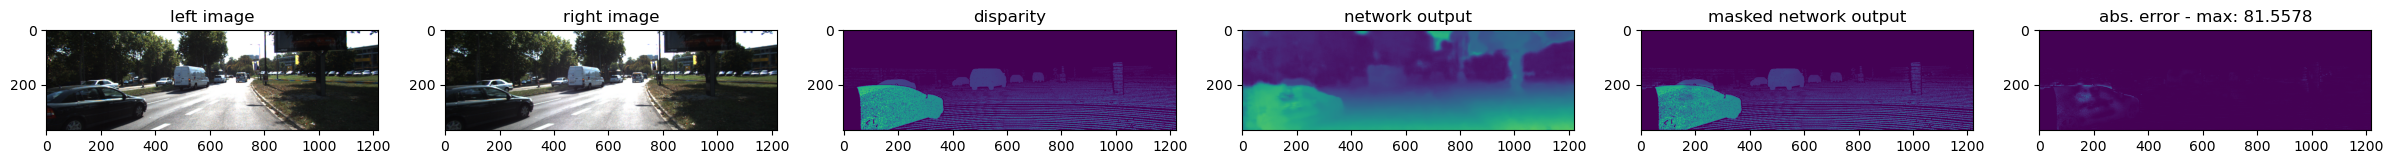

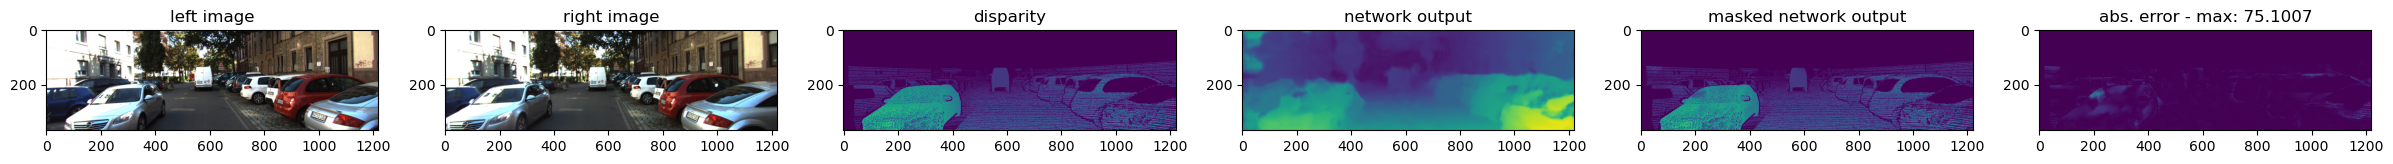

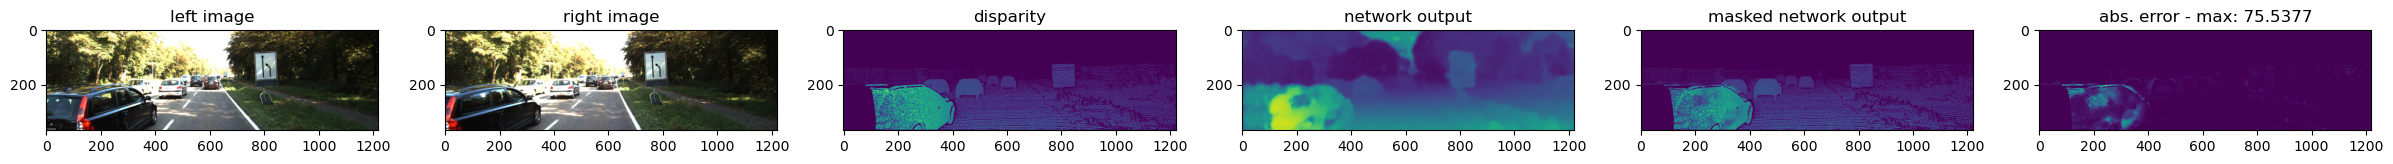

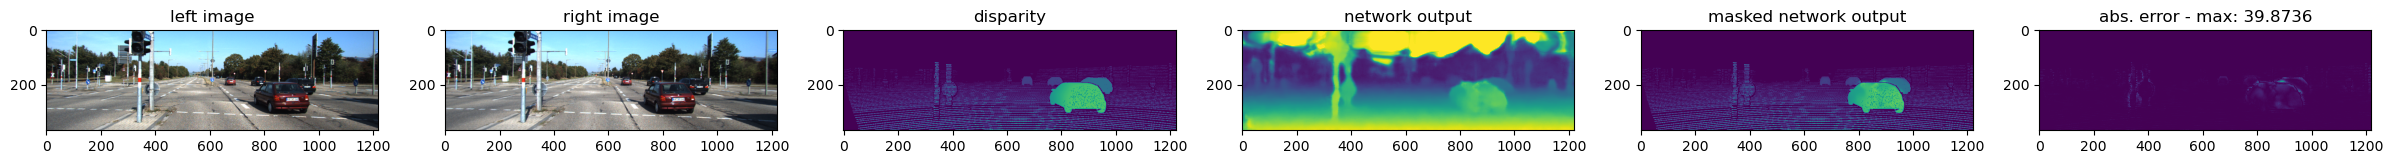

In [17]:
plt.style.use('default')
for i in range(imgs_left.shape[0]):
    img_left = imgs_left[i]
    img_right = imgs_right[i]
    img_disparity = imgs_disparity[i]
    disp_min, disp_max = img_disparity.min(), img_disparity.max()
    mask = img_disparity == 0
    net_out = net_outs[i].clone()
    
    _, axes = plt.subplots(1, 6, figsize=(30, 5))
    axes[0].imshow(inv_normalize(img_left).permute(1,2,0))
    axes[0].set_title('left image')
    
    axes[1].imshow(inv_normalize(img_right).permute(1,2,0))
    axes[1].set_title('right image')
    
    axes[2].imshow(img_disparity.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[2].set_title('disparity')

    axes[3].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[3].set_title('network output')

    net_out[mask] = 0
    axes[4].imshow(net_out.squeeze(), vmin=disp_min, vmax=disp_max)
    axes[4].set_title('masked network output')
    
    err = torch.abs(img_disparity.squeeze() - net_out.squeeze())
    axes[5].imshow(err)
    axes[5].set_title(f'abs. error - max: {err.max() :.4f}')

    plt.show()